# Setup

In [1]:
# Basics
import anndata as ad
import scvelo as scv
import pandas as pd
import random
import math

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from gseapy.plot import barplot

# cellDancer
import celldancer as cd
import celldancer.utilities as cdutil
import celldancer.cdplt as cdplt
from celldancer.utilities import export_velocity_to_dynamo
from celldancer.cdplt import colormap

# Dynamo
import dynamo as dyn
from dynamo.tools.graph_operators import build_graph, div, potential

The preparations take a significant amount of time. Here, we only show plots output.

See `Objects_preparations.ipynb` for object creation.

In [2]:
adata = ad.read_h5ad("astrocytes.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 9076 × 19407
    obs: 'annotation', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

# Prepare dataset

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30) # cell amount will influence the setting of n_neighbors

Filtered out 9660 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:28) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
# Only run once
cellDancer_df = cdutil.adata_to_df_with_embed(
    adata,
    us_para=["Mu", "Ms"],
    cell_type_para="annotation",
    embed_para="X_umap",
    save_path="celldancer_astro.csv"
)

100%|██████████| 2000/2000 [01:42<00:00, 19.60it/s]


# Estimate velocity

Here, we use cellDancer to estimate velocity. The plotting is not pretty, please refer to streamline plots below. We observe two trajectories, one going to reactive cells as expected.

In [7]:
# Only run once
cellDancer_df = cd.velocity(cellDancer_df, permutation_ratio=0.5, n_jobs=32)

Using /work/msa/01_notebooks/cellDancer_velocity_2024-02-01 09-44-30 as the output path.
Arranging genes for parallel job.
2000  genes were arranged to  63  portions.



Velocity Estimation: 100%|██████████| 63/63 [21:53<00:00, 19.30s/it]
                                                                    

In [8]:
# Compute cell velocity - only run once
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df[1], projection_neighbor_size=100)

In [9]:
cols = []
levels = cellDancer_df["clusters"].unique()
for i in range(0, len(levels)):
    cols.append(levels[i])

color_mapping = dict(zip(levels, random.sample(colormap.color_template, 5)))

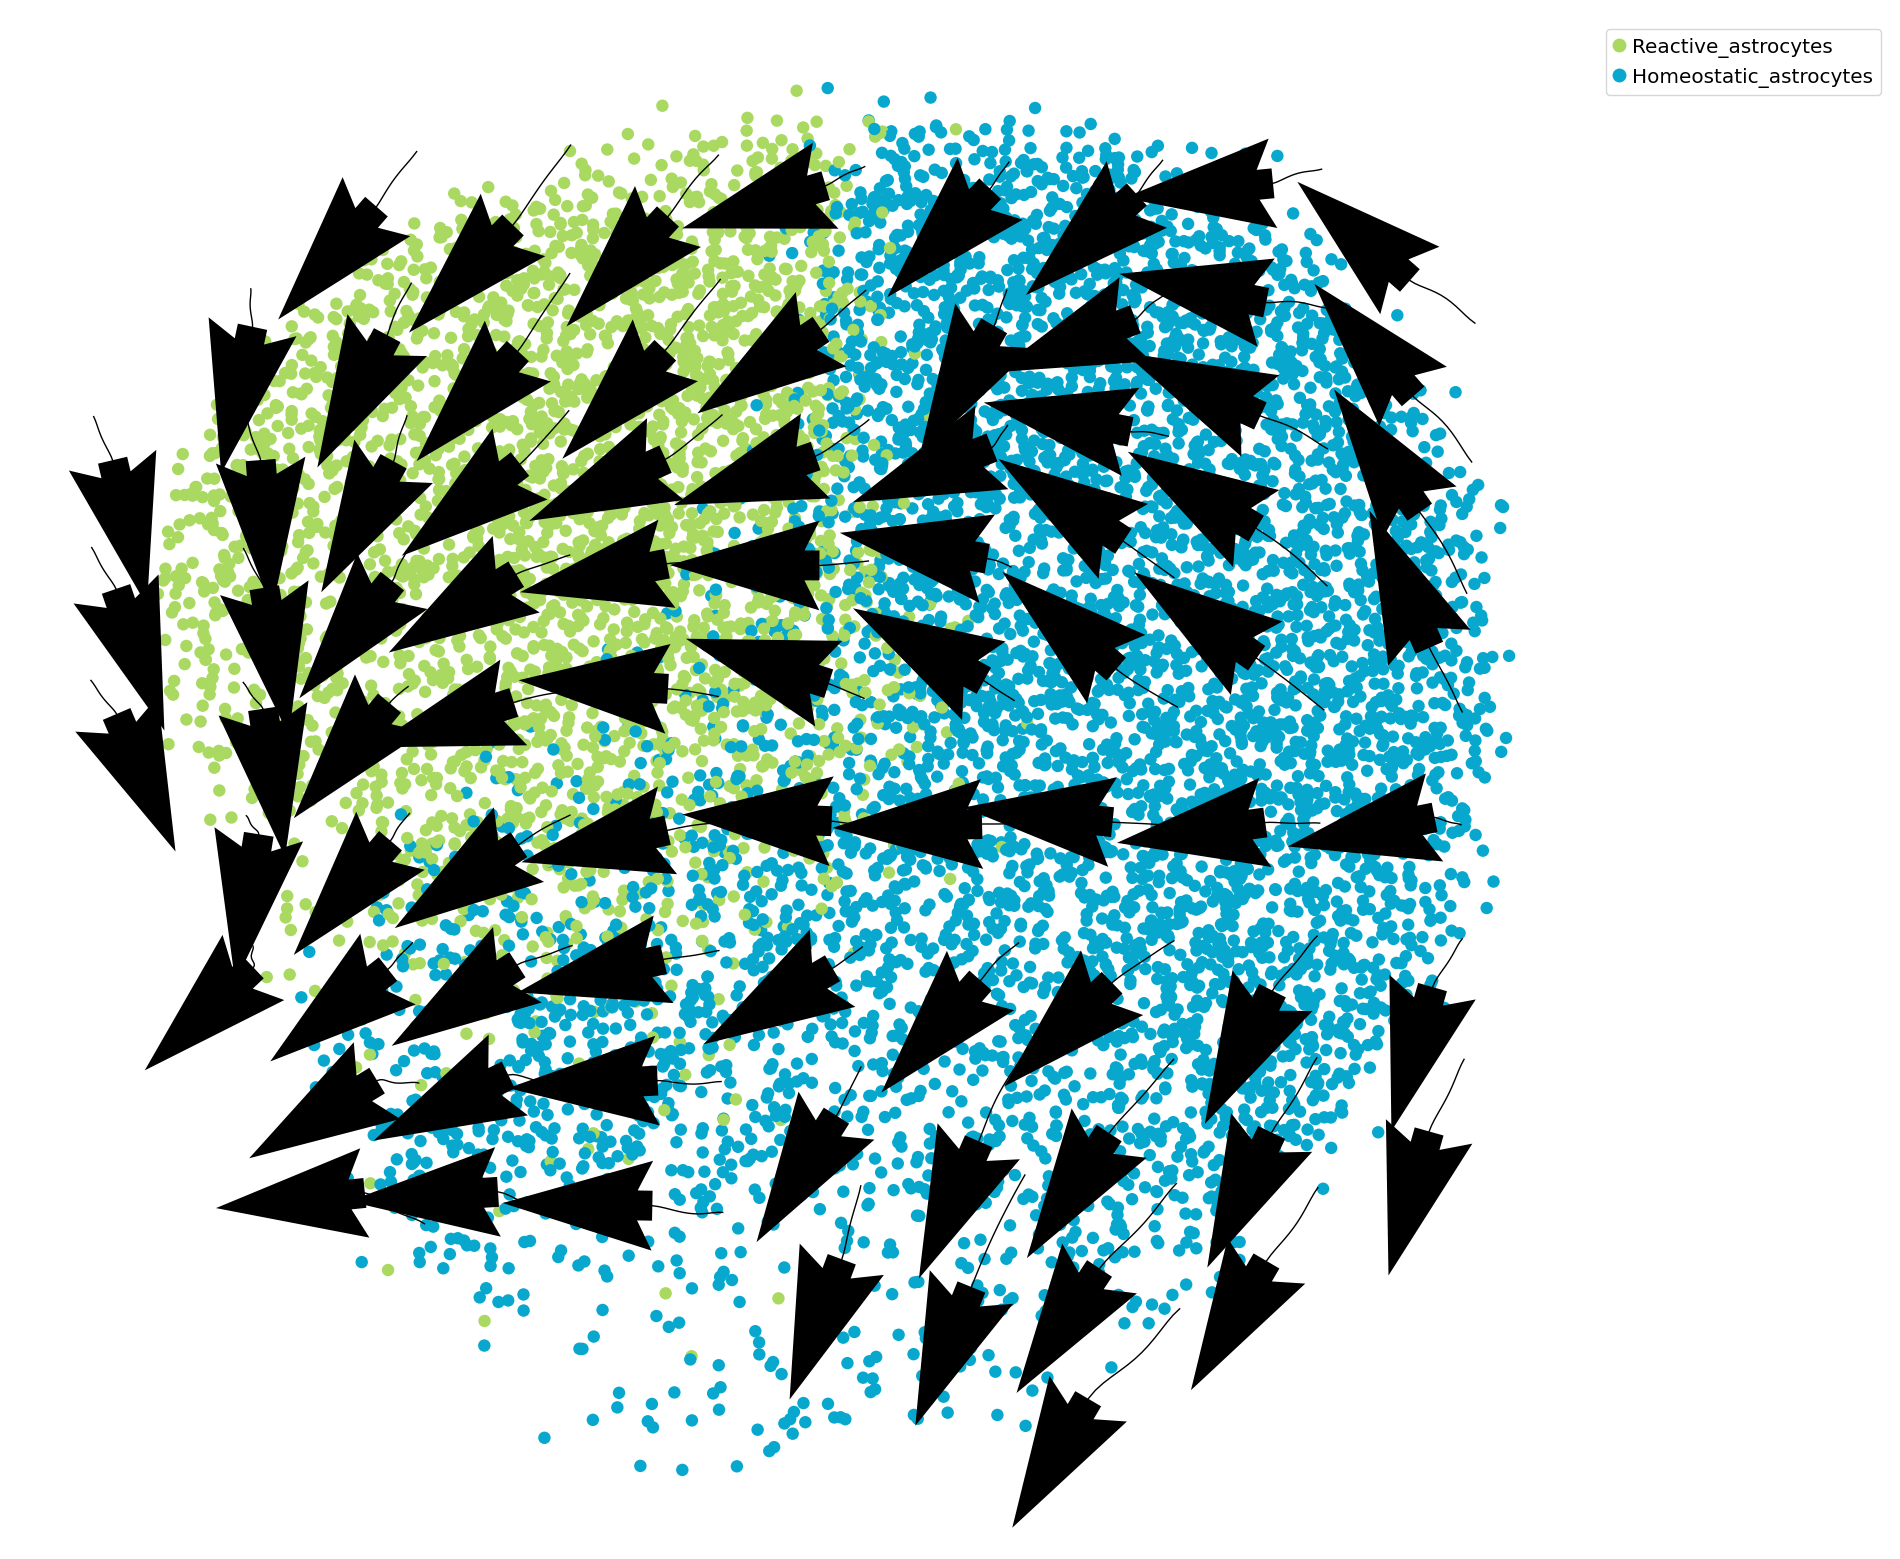

In [10]:
# Plot cell velocity
fig, ax = plt.subplots(figsize=(10,10))
im = cdplt.scatter_cell(ax, cellDancer_df, colors = color_mapping, alpha=1, s=20, velocity=True, legend='on', min_mass=10, arrow_grid=(10,10))
ax.axis('off')
plt.show()

In [13]:
# Save CD results - only once
cellDancer_df.to_pickle("celldancer_astro.pickle")

# Dynamo

In [3]:
# Load data
cellDancer_df = pd.read_pickle("celldancer_astro.pickle")

In [14]:
cellDancer_df

cellIndex gene_name  unsplice    splice  unsplice_predict  \
0                 0   TTN-AS1  1.714091  0.039762          1.575524   
1                 1   TTN-AS1  1.334386  0.000000          1.347906   
2                 2   TTN-AS1  1.479657  0.055712          1.323140   
3                 3   TTN-AS1  1.220618  0.000000          1.242144   
4                 4   TTN-AS1  1.316247  0.000000          1.330954   
...             ...       ...       ...       ...               ...   
18151995       9071   CCDC175  0.000000  0.000000          0.013621   
18151996       9072   CCDC175  0.085392  0.021534          0.089622   
18151997       9073   CCDC175  0.131874  0.015051          0.133523   
18151998       9074   CCDC175  0.006427  0.000000          0.019147   
18151999       9075   CCDC175  0.000000  0.000000          0.013621   

          splice_predict     alpha      beta     gamma      loss  ...  \
0              -0.123821  0.293500  2.423739  2.450236  0.016049  ...   
1               0.034020  0.298353  2.396773  2.421480  0.016049  ...   
2              -0.199082  0.235008  2.452648  2.469405  0.016049  ...   
3               0.031199  0.279111  2.402889  2.424129  0.016049  ...   
4               0.033571  0.295240  2.397752  2.421905  0.016049  ...   
...                  ...       ...       ...       ...       ...  ...   
18151995        0.000000  0.052770  0.329055  0.361970  0.022693  ...   
18151996        0.031420  0.119047  0.320385  0.358964  0.022693  ...   
18151997        0.038493  0.163260  0.317012  0.356061  0.022693  ...   
18151998        0.001531  0.057191  0.327986  0.361466  0.022693  ...   
18151999        0.000000  0.052770  0.329055  0.361970  0.022693  ...   

         velocity1 velocity2  alpha_umap1  alpha_umap2  beta_umap1  \
0        -0.065786 -0.082263     4.899288    -4.838318    8.705705   
1              NaN       NaN     0.151831    -2.568777    7.765032   
2              NaN       NaN    -0.671039    -2.126876    9.610082   
3              NaN       NaN     2.483421    20.785336   -2.123071   
4              NaN       NaN    -3.574980    11.703396    1.528884   
...            ...       ...          ...          ...         ...   
18151995 -0.253036  0.160222    16.099213     6.524858   11.725671   
18151996       NaN       NaN    15.719319    16.431898    1.625155   
18151997       NaN       NaN    15.066401     6.659019    7.012310   
18151998       NaN       NaN     2.951613    -3.870689    7.229275   
18151999       NaN       NaN     7.635193    -4.930254    8.706049   

          beta_umap2  gamma_umap1  gamma_umap2  alpha_beta_gamma_umap1  \
0           6.438925     1.889888     0.850813                3.866400   
1           7.958449     1.878387    -1.546903                0.038171   
2           8.767469     1.139899    -1.778256               -0.239297   
3           8.127720    11.471348     5.180099                1.065719   
4          10.236843     7.993371     2.668306               -1.883830   
...              ...          ...          ...                     ...   
18151995   -2.029711     2.177303    10.060312               14.260429   
18151996   11.721815     5.425242     4.441959               14.593148   
18151997   11.293520     2.784688     3.033626               13.284284   
18151998    8.380146     2.520153     0.704383                2.119834   
18151999    4.482956    -1.440250    -1.956254                5.044569   

          alpha_beta_gamma_umap2  
0                      -2.386646  
1                      -1.526016  
2                      -1.440956  
3                      13.938509  
4                       7.391093  
...                          ...  
18151995                2.229716  
18151996               11.742170  
18151997                2.947695  
18151998               -2.057397  
18151999               -3.120039  

[18152000 rows x 25 columns]

In [15]:
cols = []
levels = cellDancer_df["clusters"].unique()
for i in range(0, len(levels)):
    cols.append(levels[i])

color_mapping = dict(zip(levels, random.sample(colormap.color_template, 5)))

In [16]:
# Read adata again
adata = ad.read_h5ad("astrocytes.h5ad")
adata = adata[adata.obs.index.isin(cellDancer_df.cellID), ]

In [17]:
adata

View of AnnData object with n_obs × n_vars = 9076 × 19407
    obs: 'annotation', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## Transfer cellDancer to Dynamo

In [18]:
# First create dynamo adata 
dyn.pp.recipe_monocle(adata, n_top_genes=4000, fg_kwargs={"shared_count": 10})
dyn.tl.dynamics(adata, model="static") 

# replace adata.layers['velocity_S'], adata.var['use_for_dynamics'], and adata.var['use_for_transition'] with cellDancer outputs.
adata = export_velocity_to_dynamo(cellDancer_df, adata)

|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...


/work/miniconda3/envs/cellDancer/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: recipe_monocle is deprecated and will be removed in a future release. Please update your code to use the new replacement function.
  


|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> filtering cells...
|-----> 9076 cells passed basic filters.
|-----> filtering gene...
|-----> 9093 genes passed basic filters.
|-----> calculating size factor...
|-----> selecting genes in layer: X, sort method: SVR...
|-----> size factor normalizing the data, followed by log1p transformation.
|-----> Set <adata.X> to normalized data
|-----> applying PCA ...
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [2171.1825s]
|-----> [Cell Cycle Scores Estimation] completed [1.9086s]
|-----> [recipe_monocle preprocess] completed [26.9449s]
|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...

In [21]:
dyn.pp.top_pca_genes(adata, n_top_genes=500)
top_pca_genes = adata.var.index[adata.var.top_pca_genes]
dyn.vf.jacobian(adata, regulators=top_pca_genes[:300], effectors=top_pca_genes[:300], sampling = "random", sample_ncells=5000)

Transforming subset Jacobian: 100%|██████████| 5000/5000 [00:27<00:00, 179.22it/s]


AnnData object with n_obs × n_vars = 9076 × 19407
    obs: 'annotation', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase', 'pca_ddhodge_sampled', 'pca_ddhodge_div', 'pca_potential', 'pca_ddhodge_potential', 'divergence_pca', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'umap_ddhodge_sampled', 'umap_ddhodge_div', 'umap_potential', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'speed_pca', 'acceleration_pca', 'curvature_pca', 'jacobian_det_pca'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b'

In [27]:
cols = []
levels = cellDancer_df["clusters"].unique()
for i in range(0, len(levels)):
    cols.append(levels[i])

color_mapping = dict(zip(levels, random.sample(colormap.color_template, 5)))

### Fractions

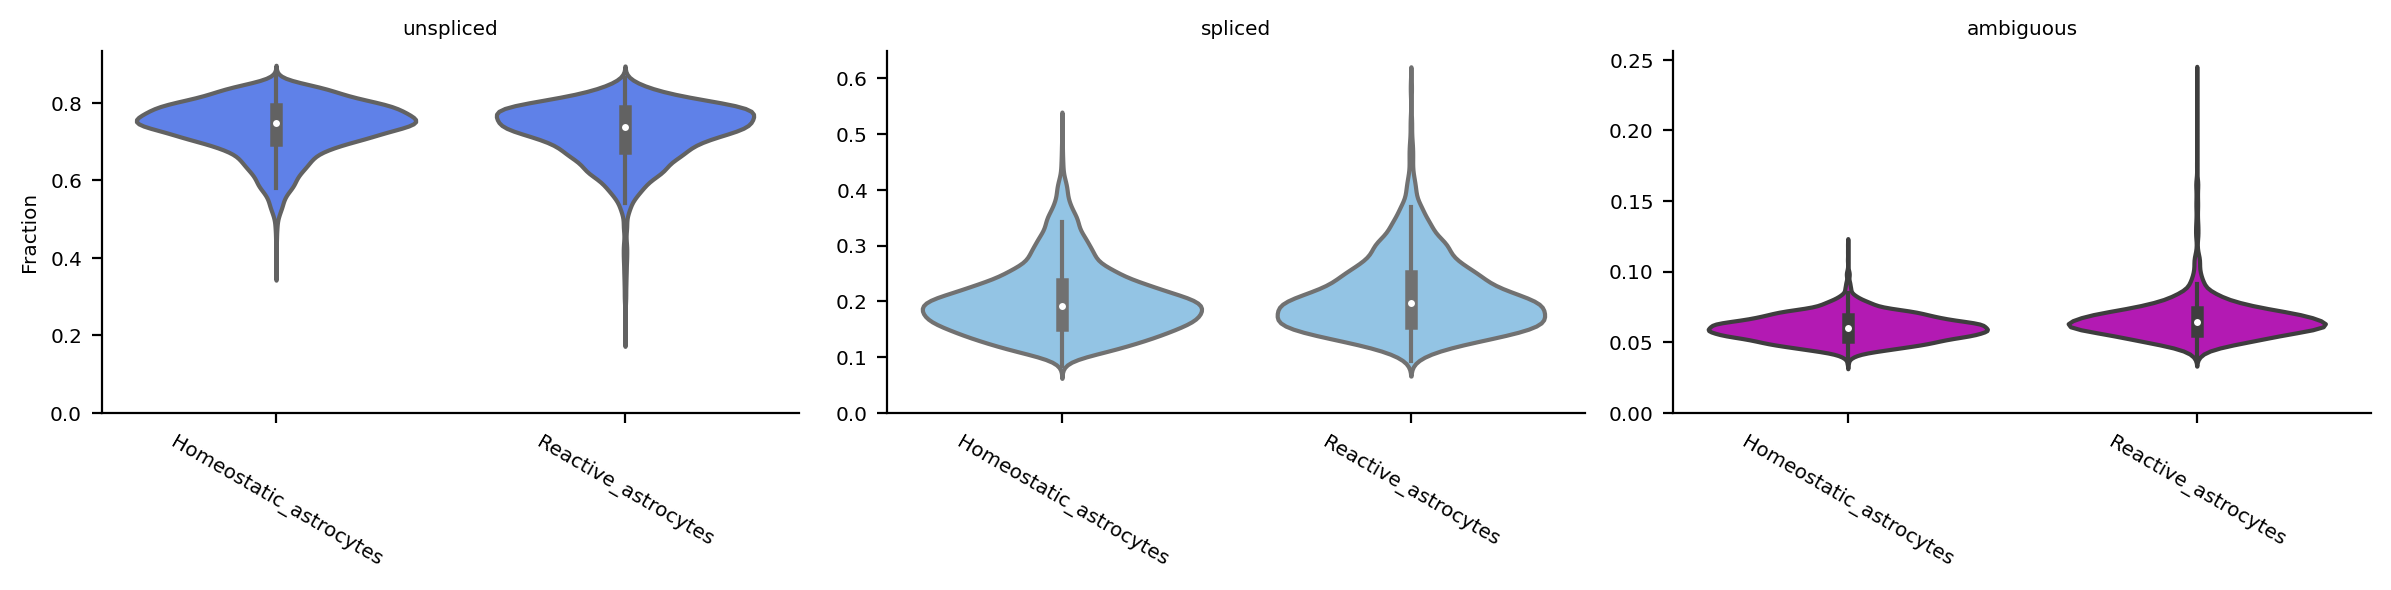

In [28]:
dyn.pl.show_fraction(adata, group = "annotation")

### Streamline plot

|-----------> plotting with basis key=X_umap
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type


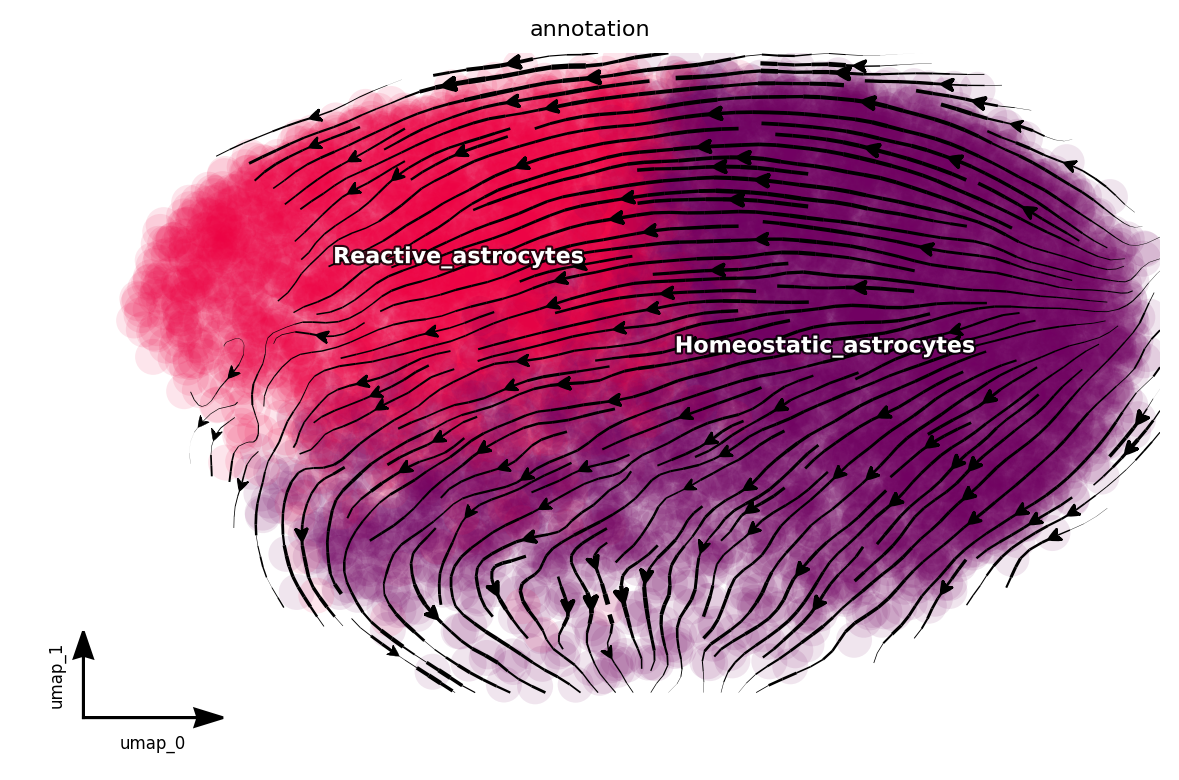

|-----------> plotting with basis key=X_pca
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type


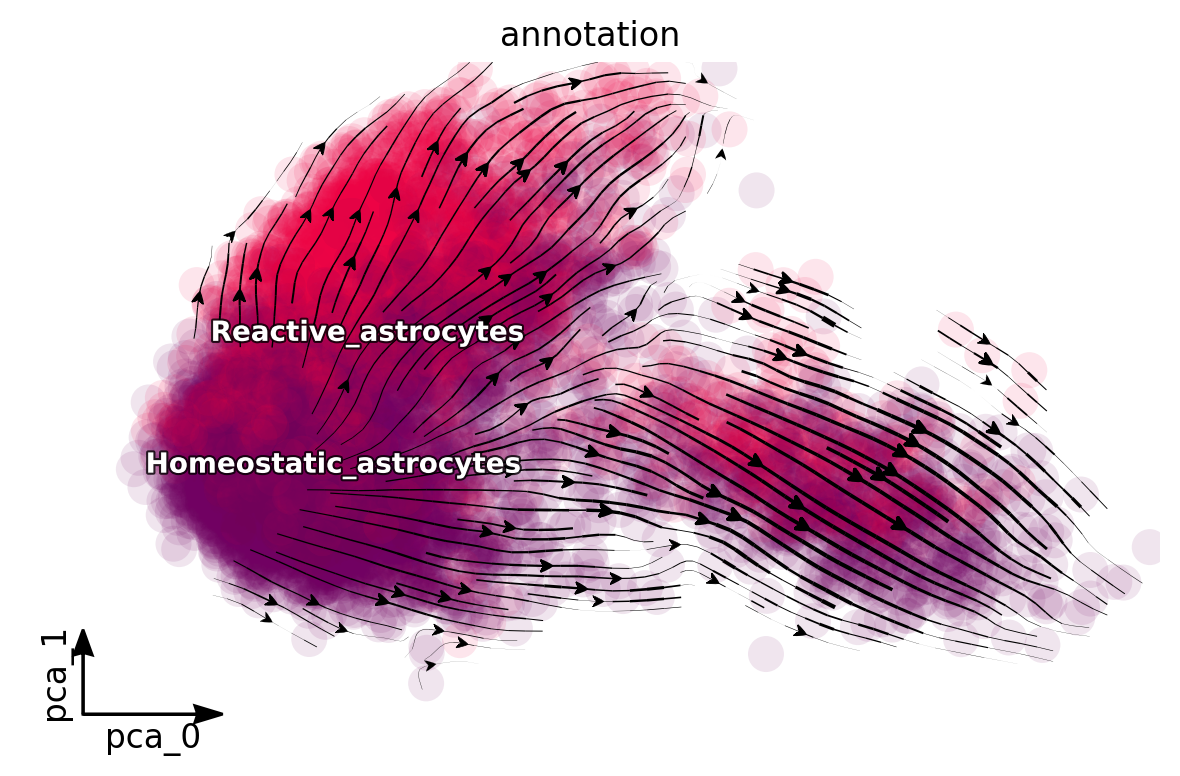

In [32]:
dyn.pl.streamline_plot(adata, color=["annotation"], basis="umap", color_key = color_mapping, show_legend="on data", show_arrowed_spines=True)
dyn.pl.streamline_plot(adata, color=["annotation"], basis="pca", color_key = color_mapping, show_legend="on data", show_arrowed_spines=True)

## Only CTRL

In [2]:
adatacp = adata[adata.obs.index.str.contains("CTRL")]
adatacp

View of AnnData object with n_obs × n_vars = 3674 × 19407
    obs: 'annotation', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase', 'pca_ddhodge_sampled', 'pca_ddhodge_div', 'pca_potential', 'pca_ddhodge_potential', 'divergence_pca', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'umap_ddhodge_sampled', 'umap_ddhodge_div', 'umap_potential', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'speed_pca', 'acceleration_pca', 'curvature_pca', 'jacobian_det_pca'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', '

### Streamline plot

In [5]:
adatacp.obs["annotation"] = adatacp.obs["annotation"].replace("Reactive_astrocytes", "AS_reactive").replace("Homeostatic_astrocytes", "AS_homeostatic")

|-----------> plotting with basis key=X_pca
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type
Saving figure to /work/msa/01_notebooks/streamline_plot_dyn_savefig.svg...
Done
|-----------> plotting with basis key=X_pca
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type


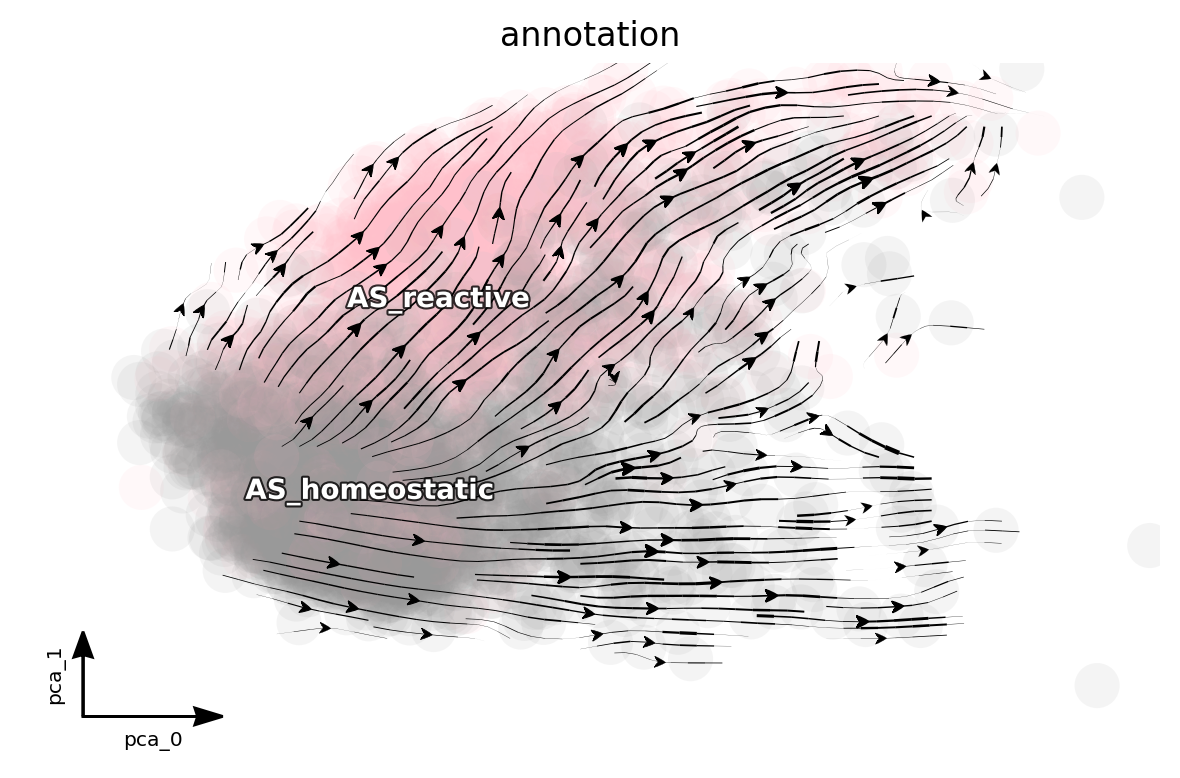

|-----------> plotting with basis key=X_umap
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type


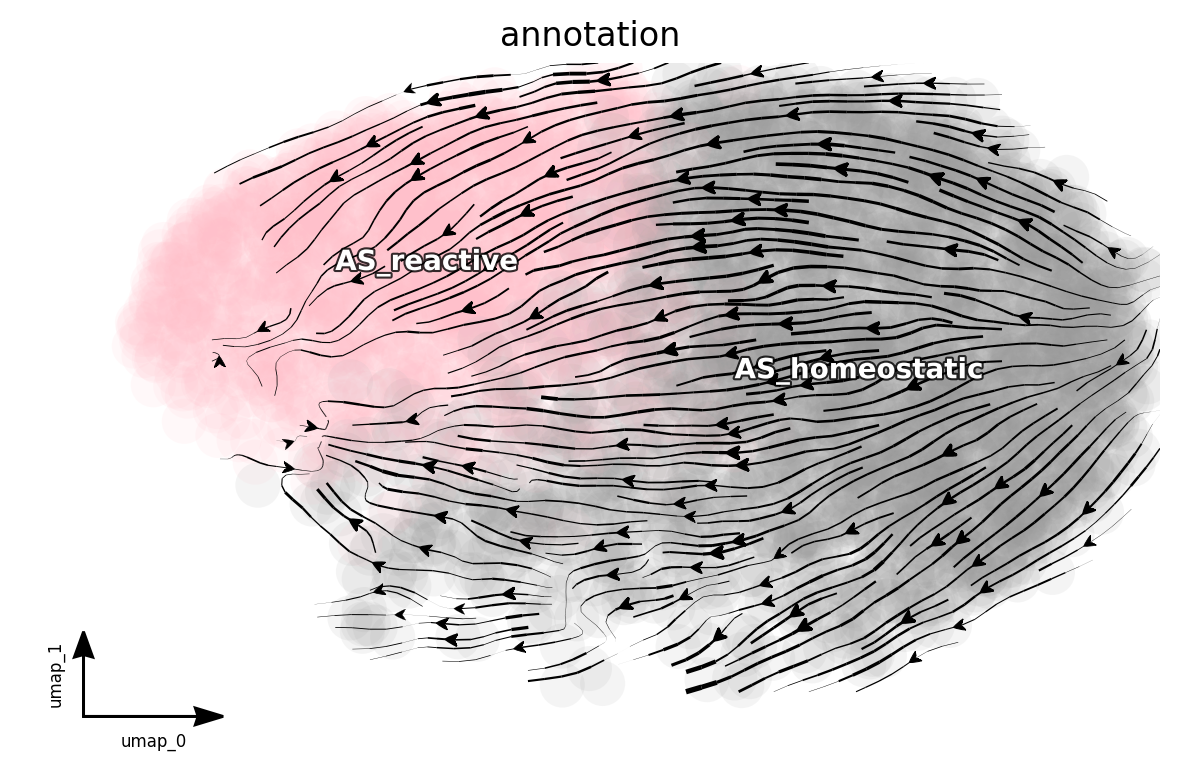

In [6]:
dyn.pl.streamline_plot(adatacp, color=["annotation"], basis="pca", color_key = color_mapping, show_legend="on data", show_arrowed_spines=True)

## Only PD

In [7]:
adatacp = adata[adata.obs.index.str.contains("PD")]
adatacp

View of AnnData object with n_obs × n_vars = 3932 × 19407
    obs: 'annotation', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase', 'pca_ddhodge_sampled', 'pca_ddhodge_div', 'pca_potential', 'pca_ddhodge_potential', 'divergence_pca', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'umap_ddhodge_sampled', 'umap_ddhodge_div', 'umap_potential', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'speed_pca', 'acceleration_pca', 'curvature_pca', 'jacobian_det_pca'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', '

In [9]:
cols = []
levels = cellDancer_df["clusters"].unique()
for i in range(0, len(levels)):
    cols.append(levels[i])

color_mapping = dict(zip(["AS_reactive","AS_homeostatic"], ["#FFC0CB","#999999"]))

### Streamline plot

In [10]:
adatacp.obs["annotation"] = adatacp.obs["annotation"].replace("Reactive_astrocytes", "AS_reactive").replace("Homeostatic_astrocytes", "AS_homeostatic")

|-----------> plotting with basis key=X_pca
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type
Saving figure to /work/msa/01_notebooks/streamline_plot_dyn_savefig.svg...
Done
|-----------> plotting with basis key=X_pca
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type


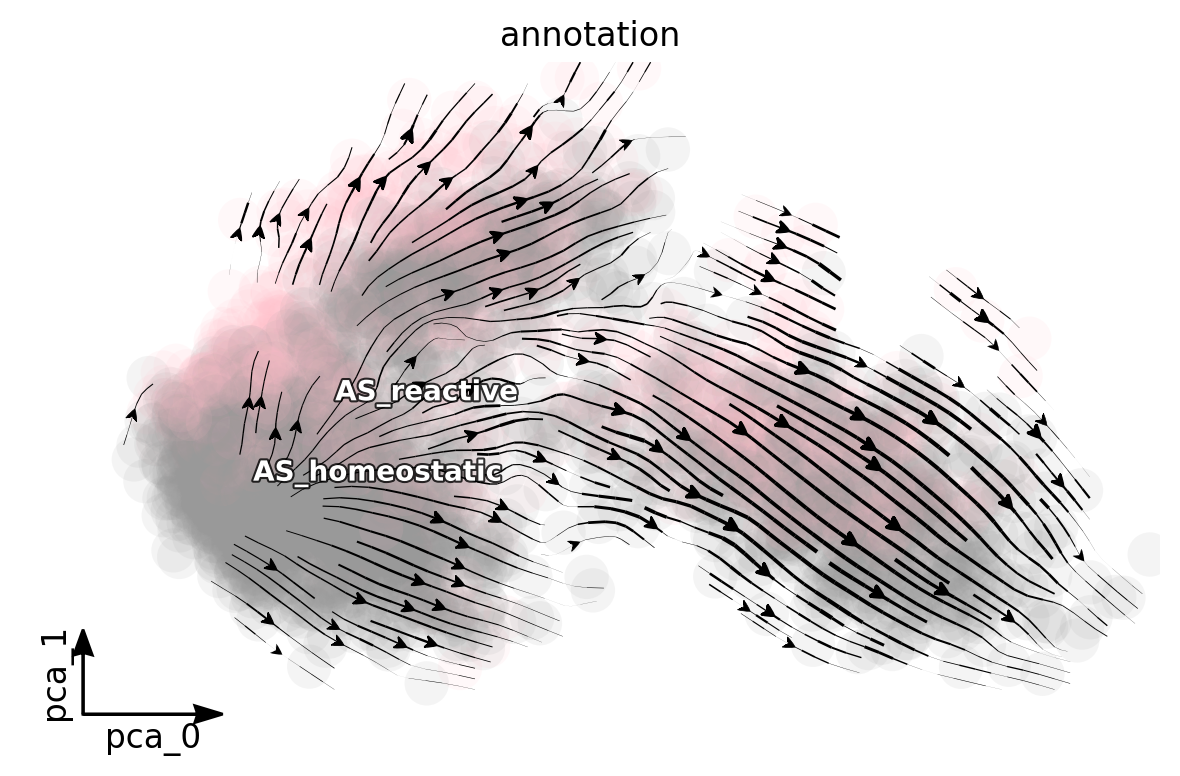

|-----------> plotting with basis key=X_umap
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type


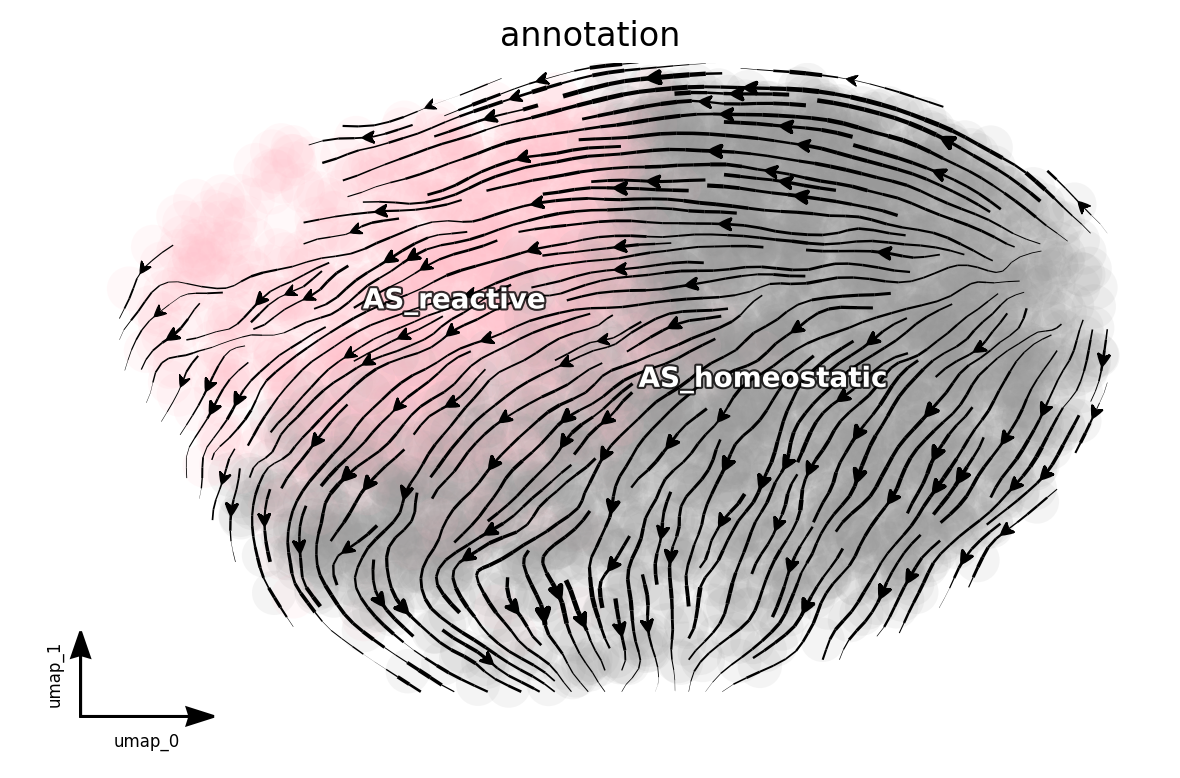

In [11]:
dyn.pl.streamline_plot(adatacp, color=["annotation"], basis="pca", color_key = color_mapping, show_legend="on data", show_arrowed_spines=True)

## Only MSA

In [12]:
adatacp = adata[adata.obs.index.str.contains("MSA")]

In [17]:
cols = []
levels = cellDancer_df["clusters"].unique()
for i in range(0, len(levels)):
    cols.append(levels[i])

color_mapping = dict(zip(["AS_reactive","AS_homeostatic"], ["#FFC0CB","#999999"]))

### Streamline plot

In [15]:
adatacp.obs["annotation"] = adatacp.obs["annotation"].replace("Reactive_astrocytes", "AS_reactive").replace("Homeostatic_astrocytes", "AS_homeostatic")

|-----------> plotting with basis key=X_pca
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type
Saving figure to /work/msa/01_notebooks/streamline_plot_dyn_savefig.svg...
Done
|-----------> plotting with basis key=X_pca
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type


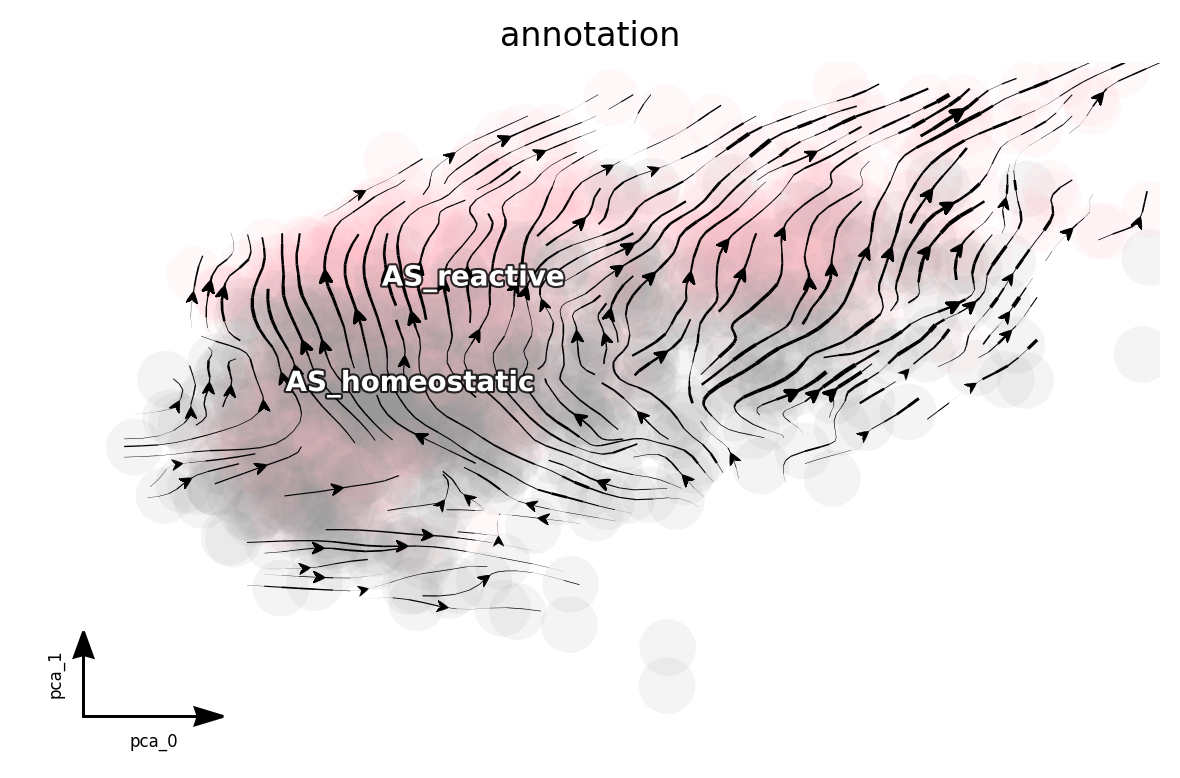

|-----------> plotting with basis key=X_umap
|-----------> skip filtering annotation by stack threshold when stacking color because it is not a numeric type


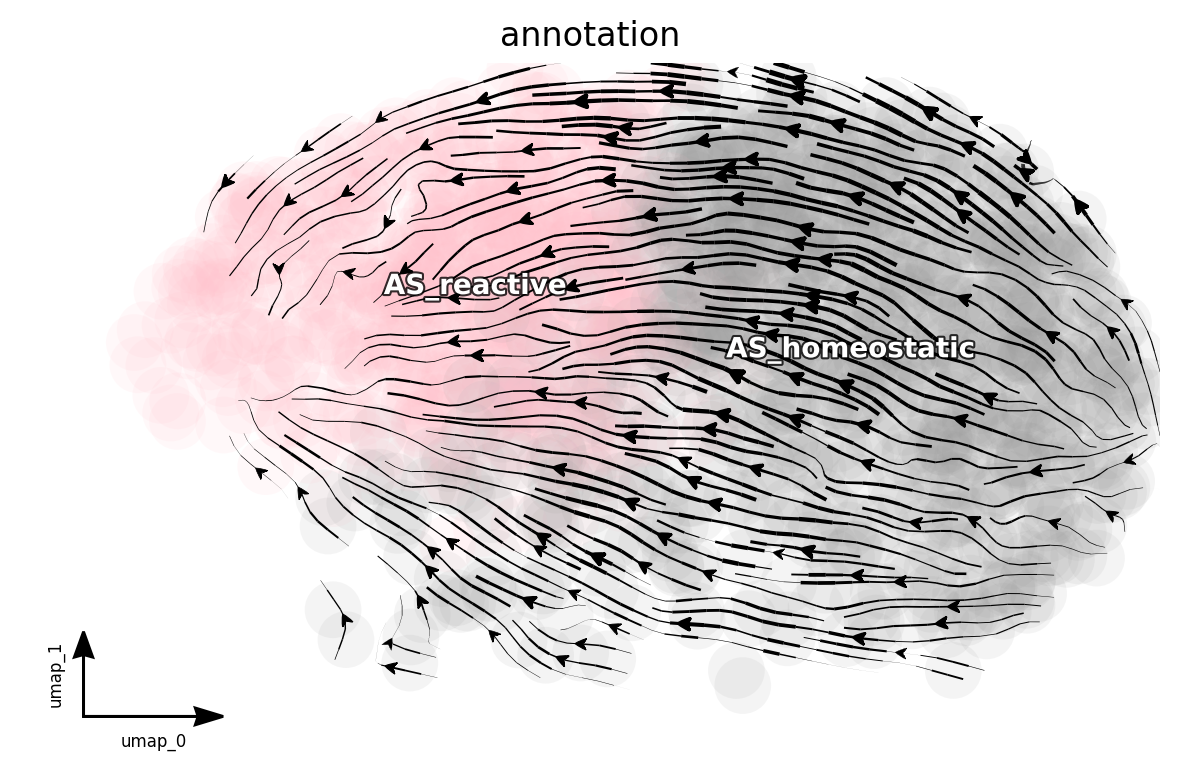

In [16]:
dyn.pl.streamline_plot(adatacp, color=["annotation"], basis="pca", color_key = color_mapping, show_legend="on data", show_arrowed_spines=True)